In [1]:
!pip install python-gdcm pydicom pylibjpeg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 61.5 MB/s eta 0:00:00


In [2]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_theme(style="whitegrid")

import cv2
import pydicom
from tqdm import tqdm

In [3]:
train_df = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/train.csv")
test_df = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/test.csv")

train_dir = '/kaggle/input/rsna-breast-cancer-detection/train_images/'
test_dir = '/kaggle/input/rsna-breast-cancer-detection/test_images/'
train_dir_converted = '/kaggle/input/rnsa-train-data-with-roi-224x224/train_images_processed_cv2_dicomsdl_512/'
train_df['image_path'] = train_df.apply(lambda x: train_dir + str(int(x.patient_id)) + '/' + str(int(x.image_id)) + '.dcm', axis=1)

In [4]:
train_df.head()

site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
0        2       10006   462822612          L   CC  61.0       0       0   
1        2       10006  1459541791          L  MLO  61.0       0       0   
2        2       10006  1864590858          R  MLO  61.0       0       0   
3        2       10006  1874946579          R   CC  61.0       0       0   
4        2       10011   220375232          L   CC  55.0       0       0   

   invasive  BIRADS  implant density  machine_id  difficult_negative_case  \
0         0     NaN        0     NaN          29                    False   
1         0     NaN        0     NaN          29                    False   
2         0     NaN        0     NaN          29                    False   
3         0     NaN        0     NaN          29                    False   
4         0     0.0        0     NaN          21                     True   

                                          image_path  
0  /kaggle/input/rsna-breast-cancer-detection/tra...  
1  /kaggle/input/rsna-breast-cancer-detection/tra...  
2  /kaggle/input/rsna-breast-cancer-detection/tra...  
3  /kaggle/input/rsna-breast-cancer-detection/tra...  
4  /kaggle/input/rsna-breast-cancer-detection/tra...

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54706 non-null  int64  
 1   patient_id               54706 non-null  int64  
 2   image_id                 54706 non-null  int64  
 3   laterality               54706 non-null  object 
 4   view                     54706 non-null  object 
 5   age                      54669 non-null  float64
 6   cancer                   54706 non-null  int64  
 7   biopsy                   54706 non-null  int64  
 8   invasive                 54706 non-null  int64  
 9   BIRADS                   26286 non-null  float64
 10  implant                  54706 non-null  int64  
 11  density                  29470 non-null  object 
 12  machine_id               54706 non-null  int64  
 13  difficult_negative_case  54706 non-null  bool   
 14  image_path            

In [6]:
train_df.describe()

site_id    patient_id      image_id           age        cancer  \
count  54706.000000  54706.000000  5.470600e+04  54669.000000  54706.000000   
mean       1.460407  32698.865262  1.079386e+09     58.543928      0.021168   
std        0.498434  18893.861534  6.183269e+08     10.050884      0.143944   
min        1.000000      5.000000  6.849100e+04     26.000000      0.000000   
25%        1.000000  16481.000000  5.458153e+08     51.000000      0.000000   
50%        1.000000  32432.000000  1.082689e+09     59.000000      0.000000   
75%        2.000000  48999.000000  1.613228e+09     66.000000      0.000000   
max        2.000000  65534.000000  2.147472e+09     89.000000      1.000000   

             biopsy      invasive        BIRADS       implant    machine_id  
count  54706.000000  54706.000000  26286.000000  54706.000000  54706.000000  
mean       0.054272      0.014953      0.772350      0.026999     54.618378  
std        0.226556      0.121365      0.590062      0.162081     44.784800  
min        0.000000      0.000000      0.000000      0.000000     21.000000  
25%        0.000000      0.000000      0.000000      0.000000     29.000000  
50%        0.000000      0.000000      1.000000      0.000000     49.000000  
75%        0.000000      0.000000      1.000000      0.000000     49.000000  
max        1.000000      1.000000      2.000000      1.000000    216.000000

# Target Column analysis

In [7]:
train_df.cancer.value_counts()

0    53548
1     1158
Name: cancer, dtype: int64

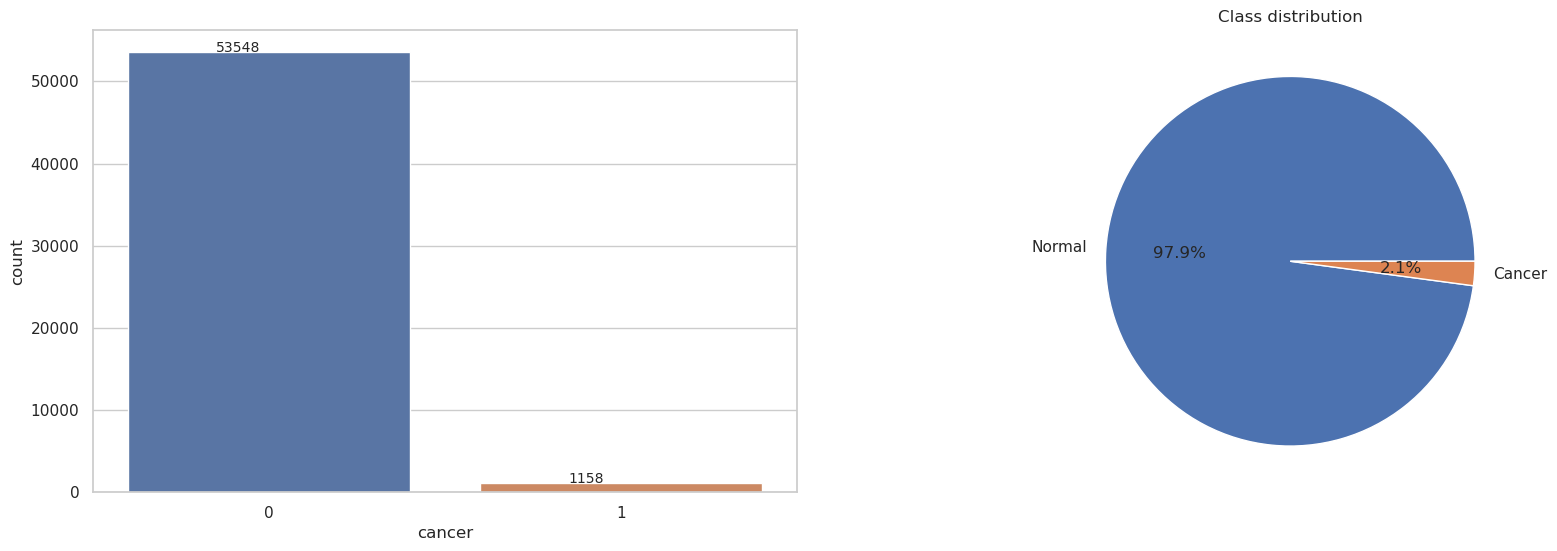

In [8]:
fig, ax = plt.subplots(1,2,figsize=(20,6))

sns.countplot(x = 'cancer', data = train_df,ax=ax[0])
for p in ax[0].patches:
    ax[0].annotate('{}'.format(int(p.get_height())), (p.get_x()+0.25, p.get_height()+0.1), fontsize=10)

plt.pie(train_df.cancer.value_counts(), labels = ['Normal', 'Cancer'], autopct='%1.1f%%')
plt.title('Class distribution');

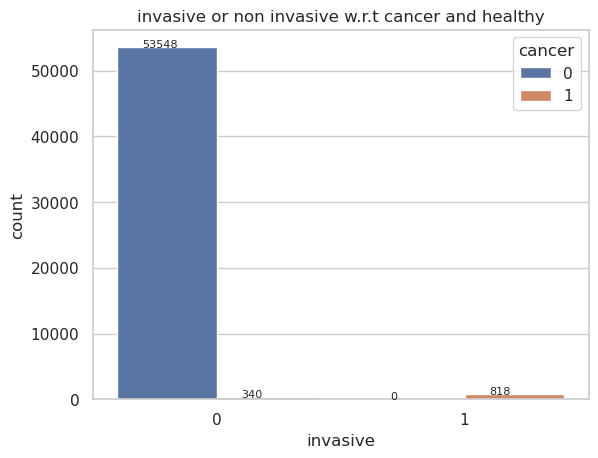

In [9]:
ax = sns.countplot(x = 'invasive', hue = 'cancer', data = train_df)
for p in ax.patches:
    ax.annotate('{}'.format(int(p.get_height())), (p.get_x()+0.10, p.get_height()+0.1), fontsize=8)
    
plt.title('invasive or non invasive w.r.t cancer and healthy');

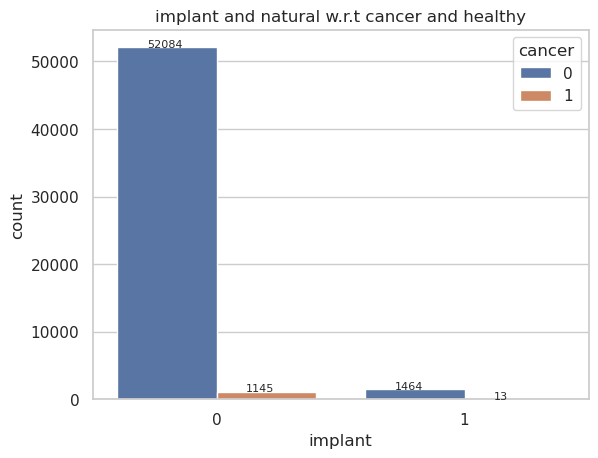

In [10]:
ax = sns.countplot(x = 'implant', hue = 'cancer', data = train_df)
for p in ax.patches:
    ax.annotate('{}'.format(int(p.get_height())), (p.get_x()+0.12, p.get_height()+0.1), fontsize=8)
    
plt.title('implant and natural w.r.t cancer and healthy');

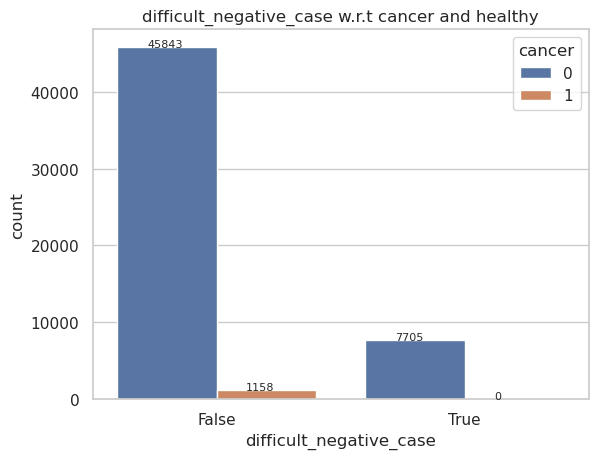

In [11]:
ax = sns.countplot(x = 'difficult_negative_case', hue = 'cancer', data = train_df)
for p in ax.patches:
    ax.annotate('{}'.format(int(p.get_height())), (p.get_x()+0.12, p.get_height()+0.1), fontsize=8)
    
plt.title('difficult_negative_case w.r.t cancer and healthy');

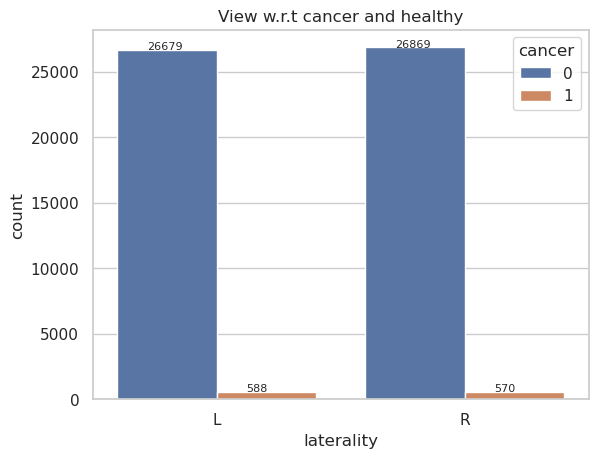

In [12]:
ax = sns.countplot(x = 'laterality', hue = 'cancer', data = train_df)
for p in ax.patches:
    ax.annotate('{}'.format(int(p.get_height())), (p.get_x()+0.12, p.get_height()+0.1), fontsize=8)
    
plt.title('View w.r.t cancer and healthy');

## Machine ID

In [13]:
print('Number of Imaging devices: ', train_df.machine_id.nunique())

Number of Imaging devices:  10


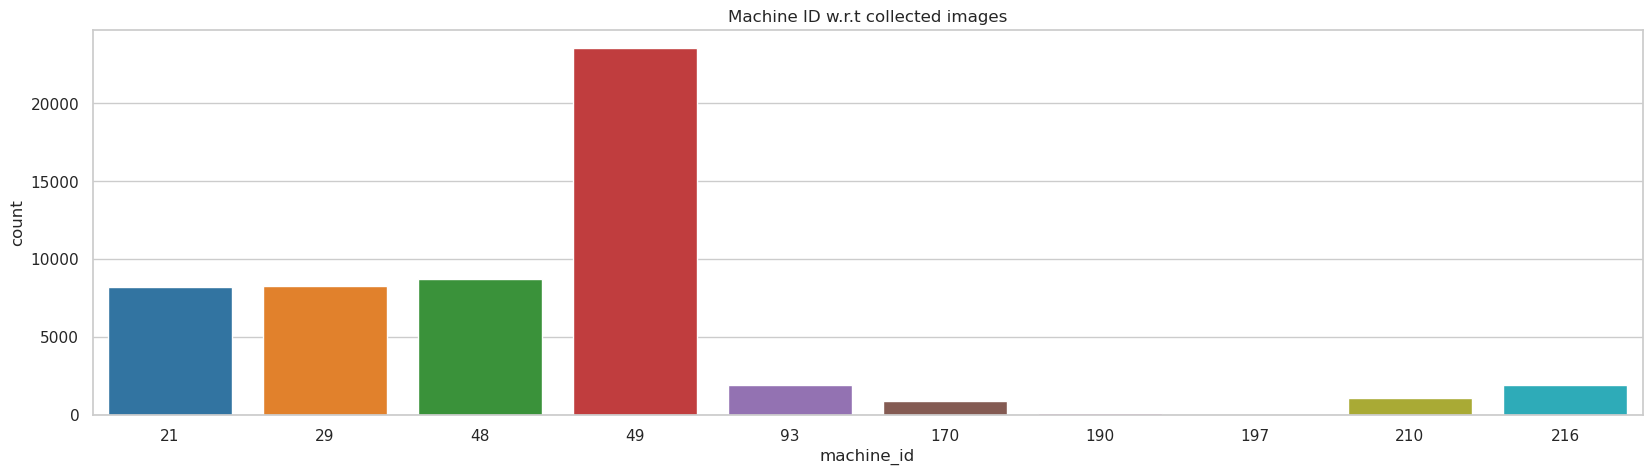

In [14]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
sns.countplot(x = 'machine_id', data = train_df, palette='tab10', ax=ax)
plt.title('Machine ID w.r.t collected images');

## Site ID

In [15]:
print('Number of Imaging sites: ', train_df.site_id.nunique())

Number of Imaging sites:  2


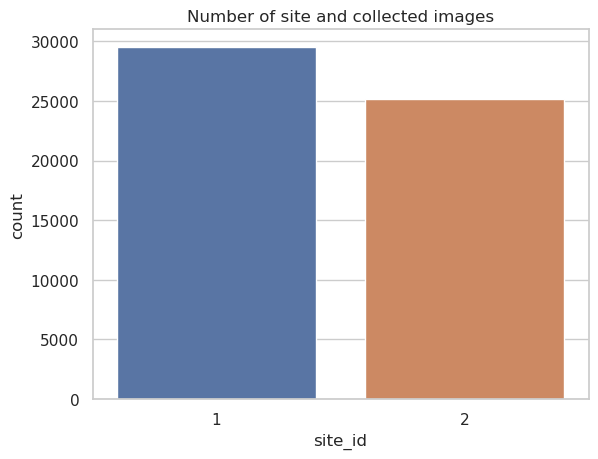

In [16]:
sns.countplot(x = 'site_id', data = train_df)
plt.title('Number of site and collected images');

## Correlation

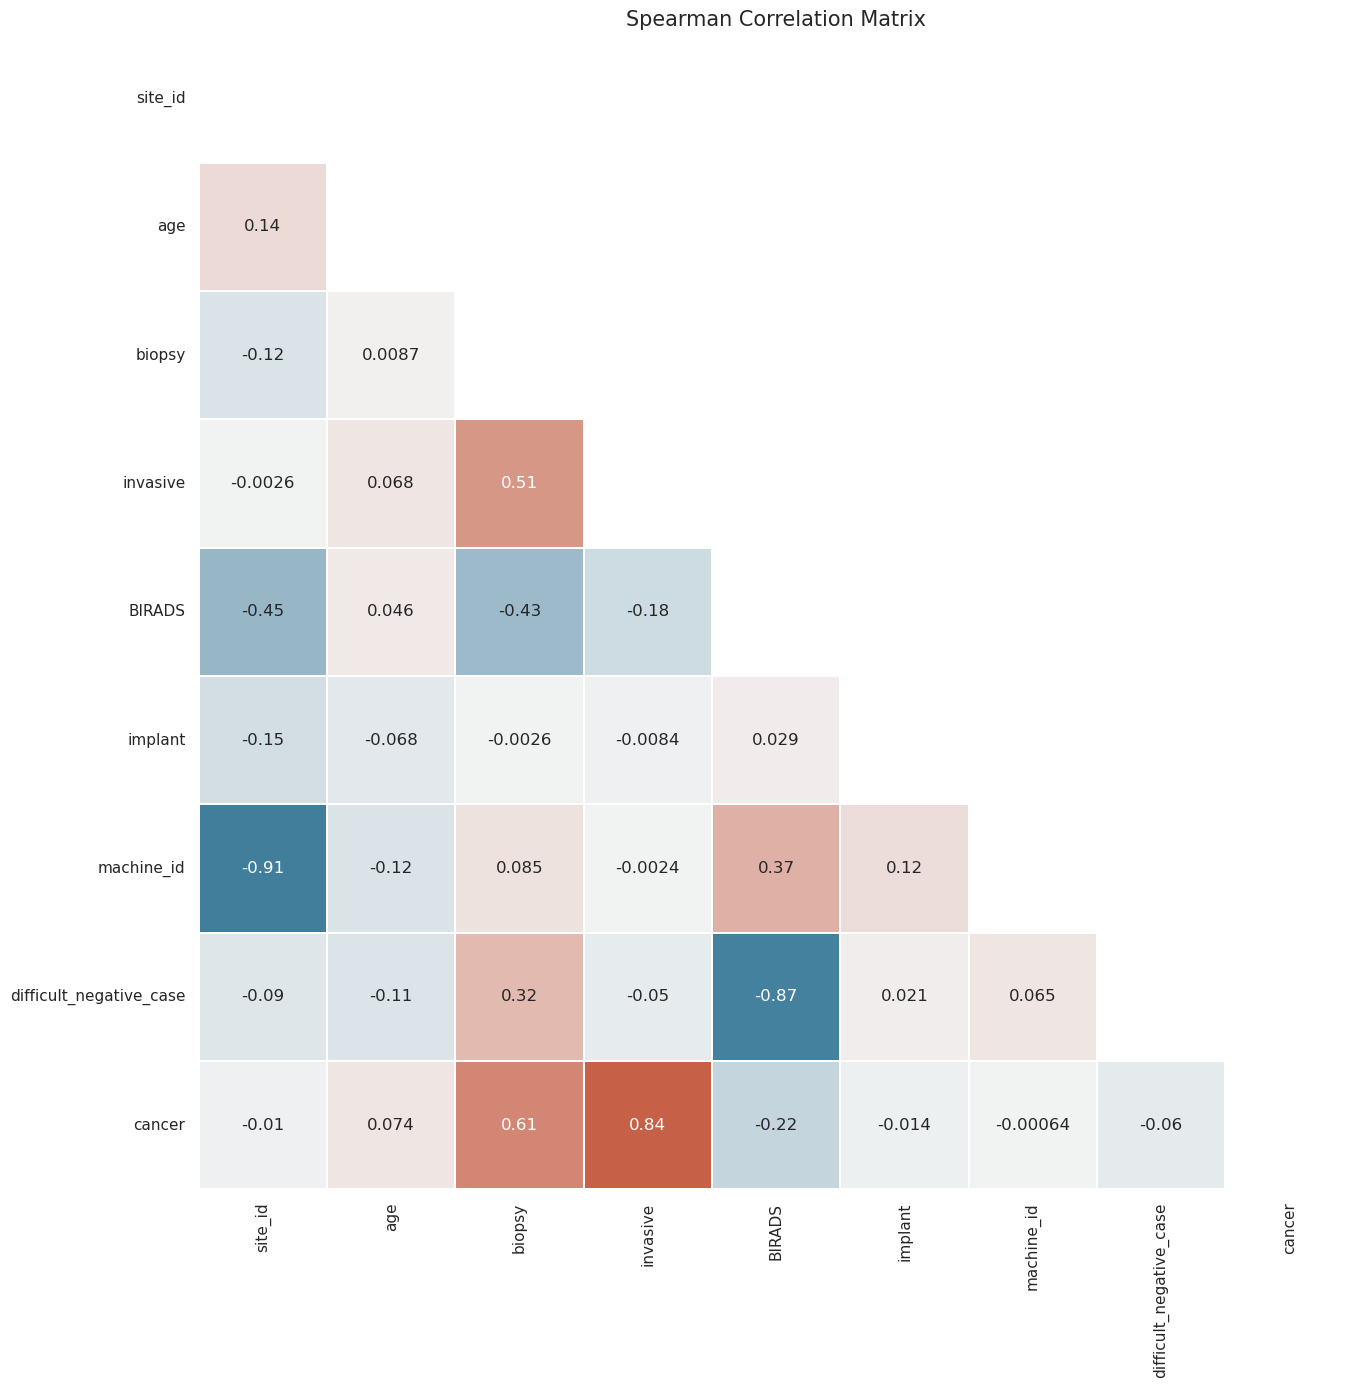

In [17]:
features = [
    "site_id", "age", "biopsy", "invasive", 
    "BIRADS", "implant", "machine_id", "density",
    "difficult_negative_case", "cancer"
]
correlation_matrix = train_df[features].corr(method="spearman")

from matplotlib.colors import SymLogNorm

f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
_ = sns.heatmap(
    correlation_matrix, 
    mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)), 
    cmap=sns.diverging_palette(230, 20, as_cmap=True), 
    center=0,
    square=True, 
    linewidths=.1, 
    cbar=False,
    ax=ax,
    annot=True,
)
_ = ax.set_title("Spearman Correlation Matrix", fontsize=15)

# Explore Images

In [18]:
def show_view(view_name, sample_size):
    
    if view_name != "LMO":
        data = train_df[train_df["view"]==view_name].sample(sample_size, random_state=24)
        image_path = data["image_path"].to_list()

        fig, axs = plt.subplots(1, sample_size, figsize=(23, 4))
        axs = axs.flatten()

        for k, path in enumerate(image_path):
            axs[k].set_title(f"{k+1}. {view_name}", 
                             fontsize = 16, weight='bold')

            img = pydicom.dcmread(path).pixel_array
            axs[k].imshow(img, cmap="turbo")
            axs[k].axis("off")

        plt.tight_layout()
        plt.show()

    else:
        path = train_df[train_df["view"]=="LMO"]["image_path"].item()
        fig, axs = plt.subplots(1, sample_size, figsize=(23, 4))
        axs = axs.flatten()
        img = pydicom.dcmread(path).pixel_array
        axs[0].imshow(img, cmap="turbo")
        axs[0].set_title(f"1. LMO", 
                         fontsize = 16, weight='bold')
        axs[0].axis("off")
        axs[1].axis("off")
        axs[2].axis("off")
        axs[3].axis("off")
        axs[4].axis("off")

        plt.tight_layout()
        plt.show()
    

## Image with respect to view

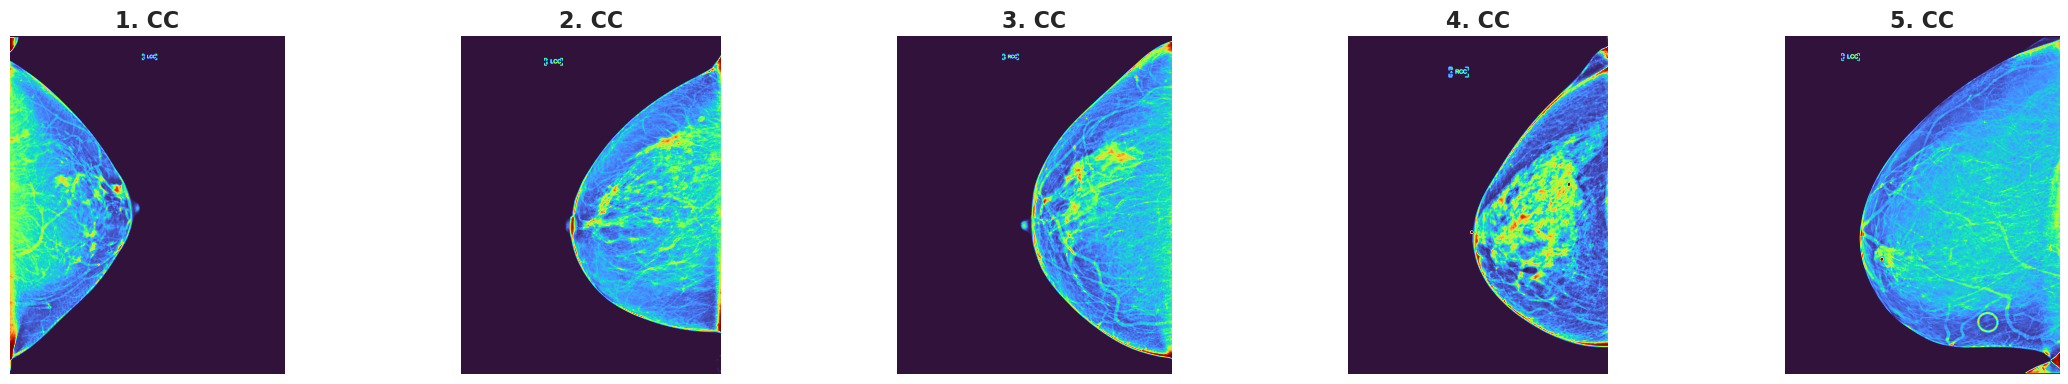

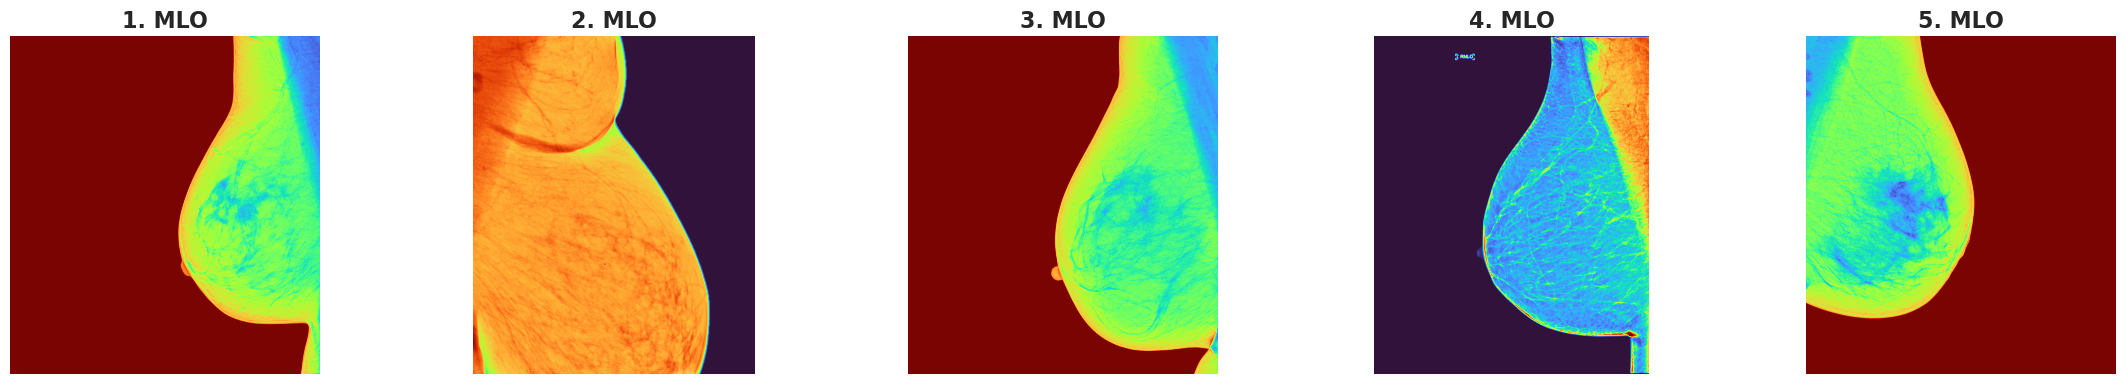

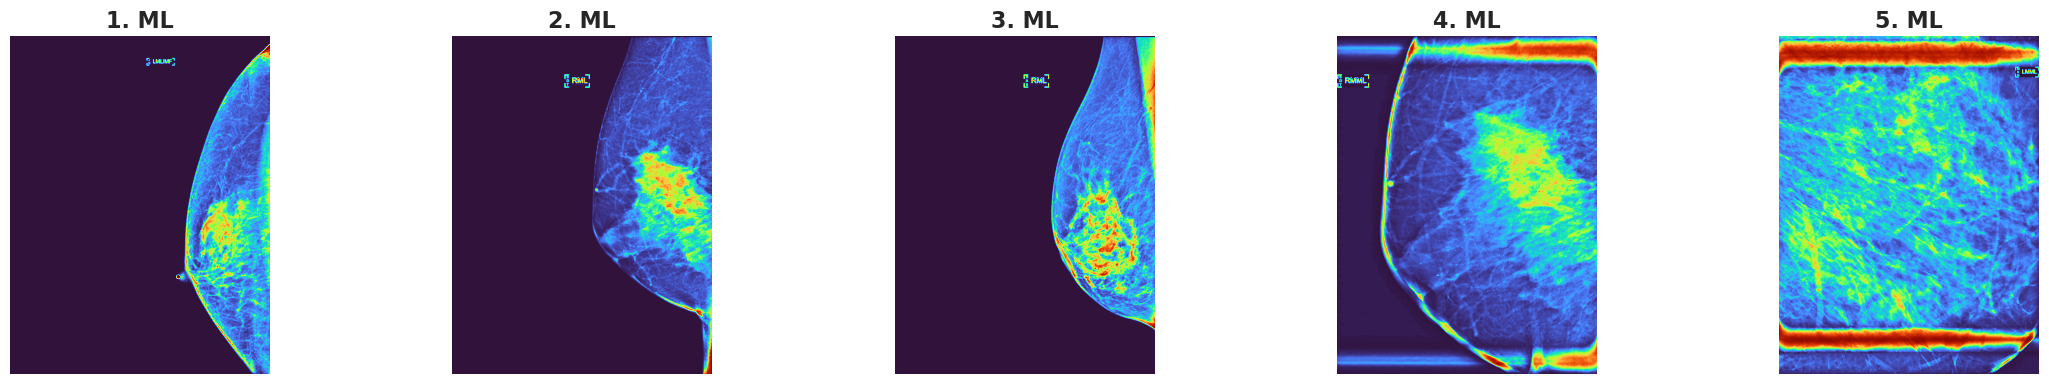

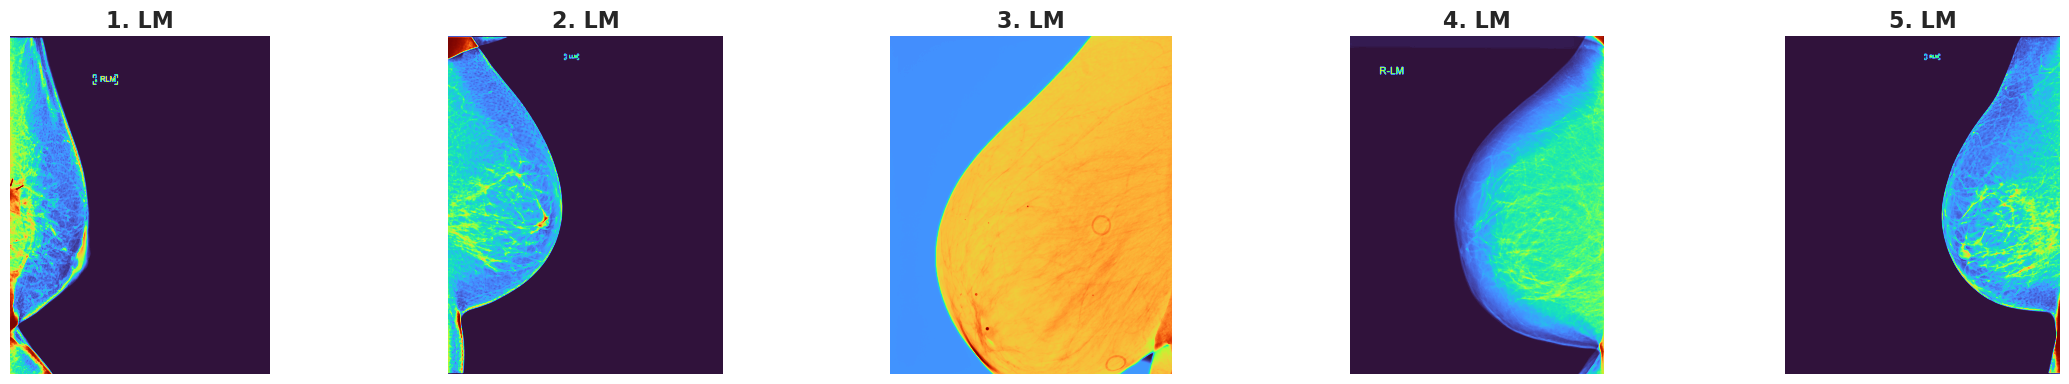

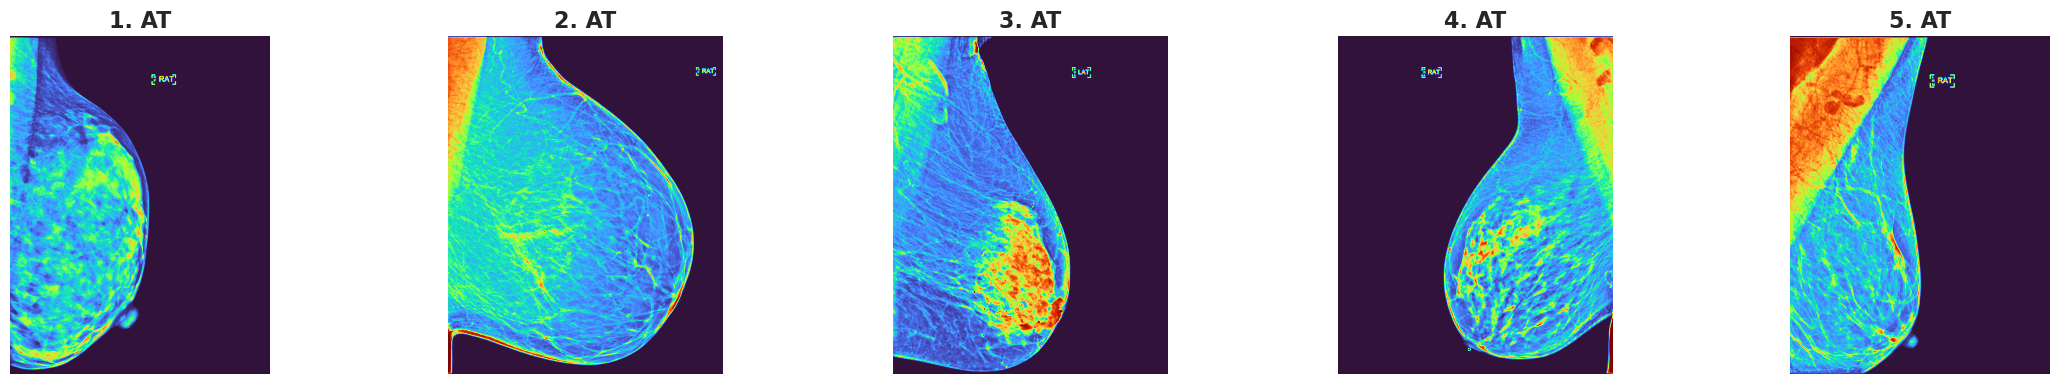

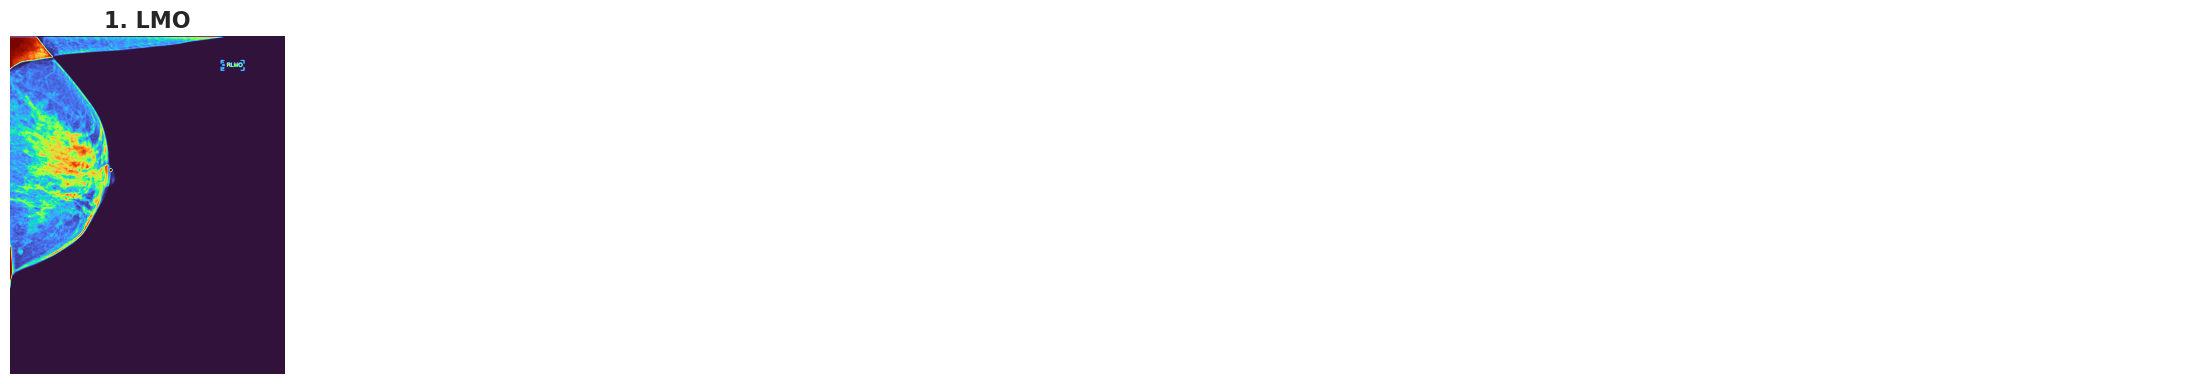

In [19]:
for view_name in train_df["view"].unique().tolist():
    show_view(view_name, sample_size=5)

In [20]:
def show_images_implant(col, col_flag, sample_size, cancer_flag=0):
    
    # Get image info
    data = train_df[train_df[col]==col_flag].sample(sample_size, random_state=24)
    if cancer_flag==1:
        data = train_df[train_df.cancer==1]
        data = train_df[train_df[col]==col_flag].sample(sample_size, random_state=24)
    image_path = data["image_path"].to_list()

    # Plot
    fig, axs = plt.subplots(1, sample_size, figsize=(23, 4))
    axs = axs.flatten()

    if col_flag == 1:
        col_flag = 'Implant'
    else:
        col_flag = 'Natural'
        
    for k, path in enumerate(image_path):
        axs[k].set_title(f"{k+1}. {col_flag}", fontsize = 10, weight='bold')

        img = pydicom.dcmread(path).pixel_array
        axs[k].imshow(img, cmap="turbo")
        axs[k].axis("off")

    plt.tight_layout()
    plt.show()
    

def show_images_cancer(col, col_flag, sample_size):
    
    # Get image info
    data = train_df[train_df[col]==col_flag].sample(sample_size, random_state=24)
    image_path = data["image_path"].to_list()

    # Plot
    fig, axs = plt.subplots(1, sample_size, figsize=(23, 4))
    axs = axs.flatten()
    
    if col_flag == 1:
        col_flag = 'Cancer'
    else:
        col_flag = 'Healthy'
        
    for k, path in enumerate(image_path):
        axs[k].set_title(f"{k+1}. {col_flag}", fontsize = 10, weight='bold')

        img = pydicom.dcmread(path).pixel_array
        axs[k].imshow(img, cmap="turbo")
        axs[k].axis("off")

    plt.tight_layout()
    plt.show()

## Breast with and without Cancer

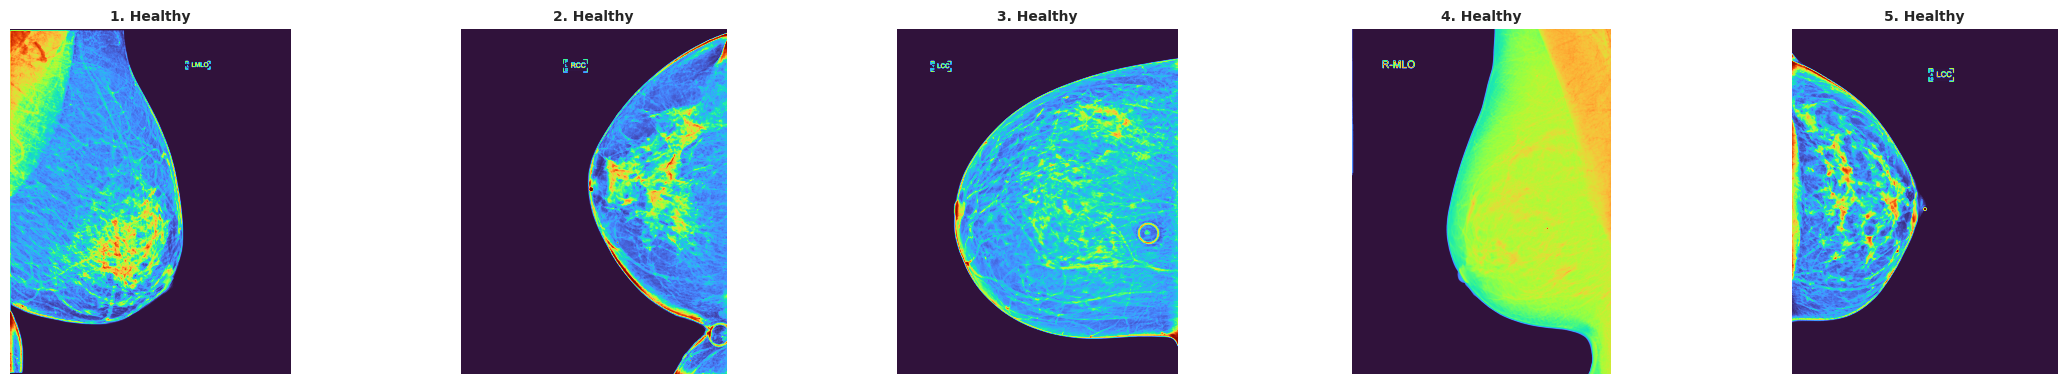

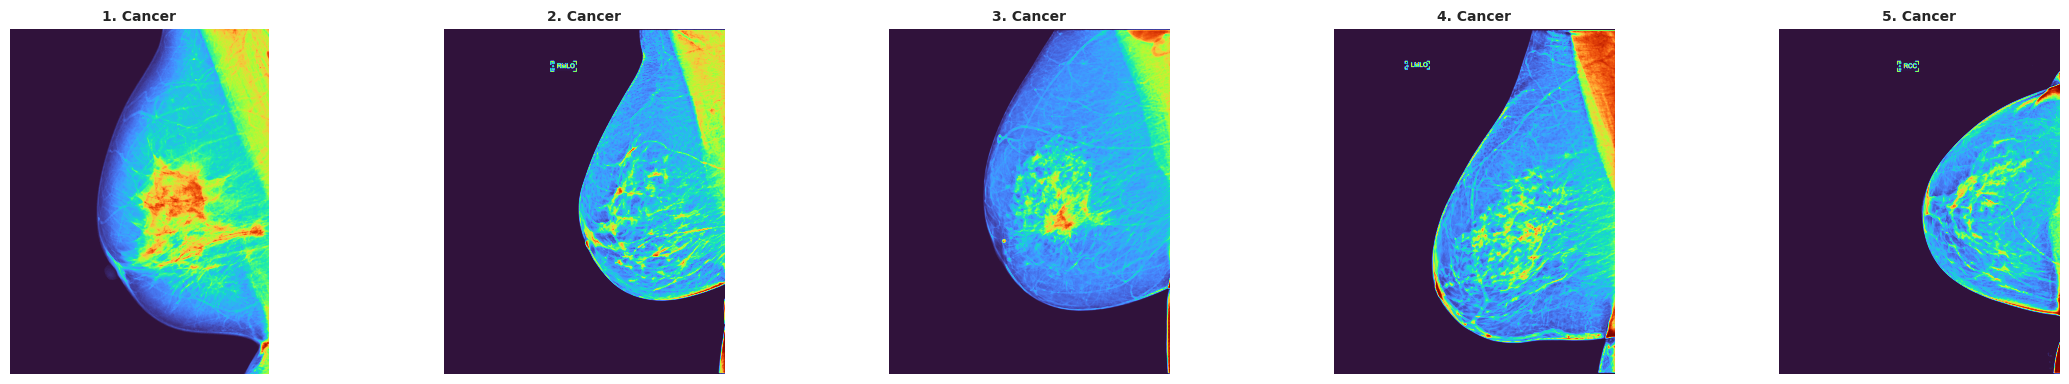

In [21]:
for cancer_flag in train_df["cancer"].unique().tolist():
    show_images_cancer(col="cancer", col_flag=cancer_flag, sample_size=5)

## Natural and  Implant Breasts without cancer

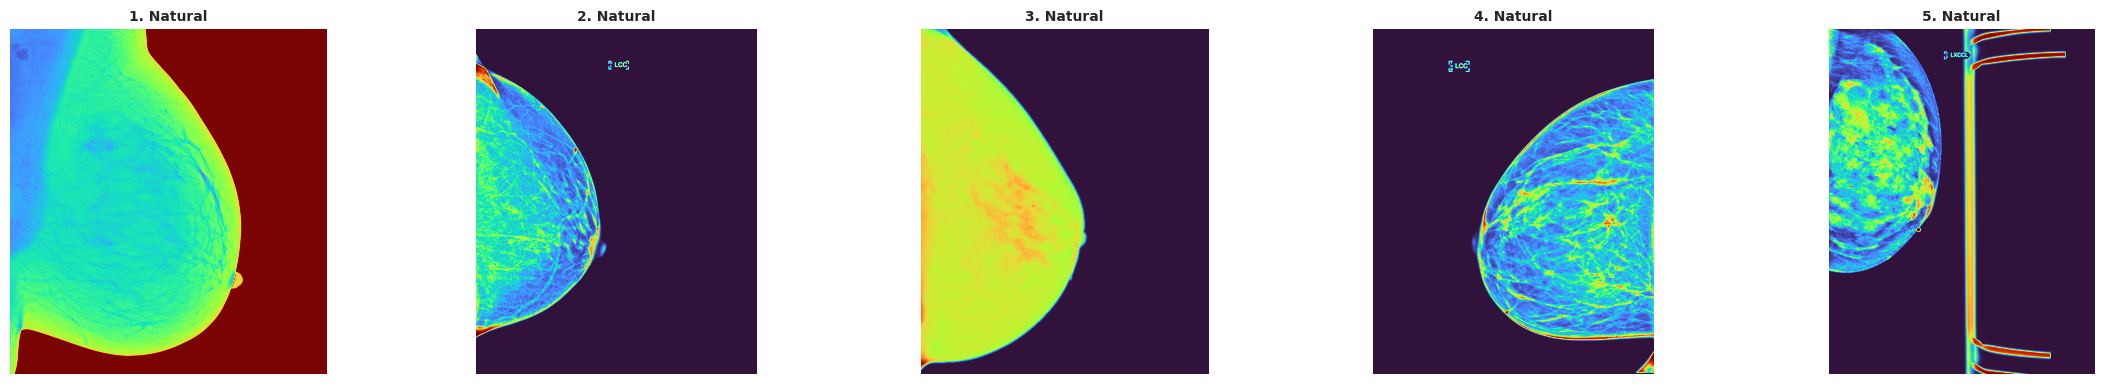

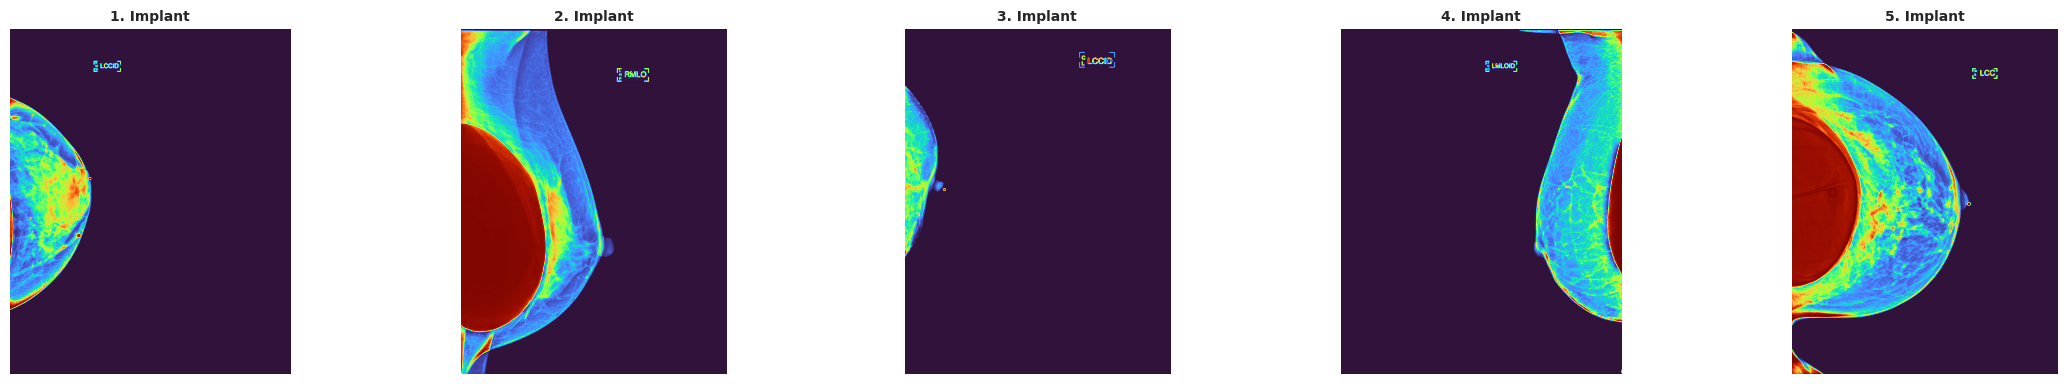

In [22]:
for implant_flag in train_df["implant"].unique().tolist():
    show_images_implant(col="implant", col_flag=implant_flag, sample_size=5)

## Natural and  Implant Breasts with cancer

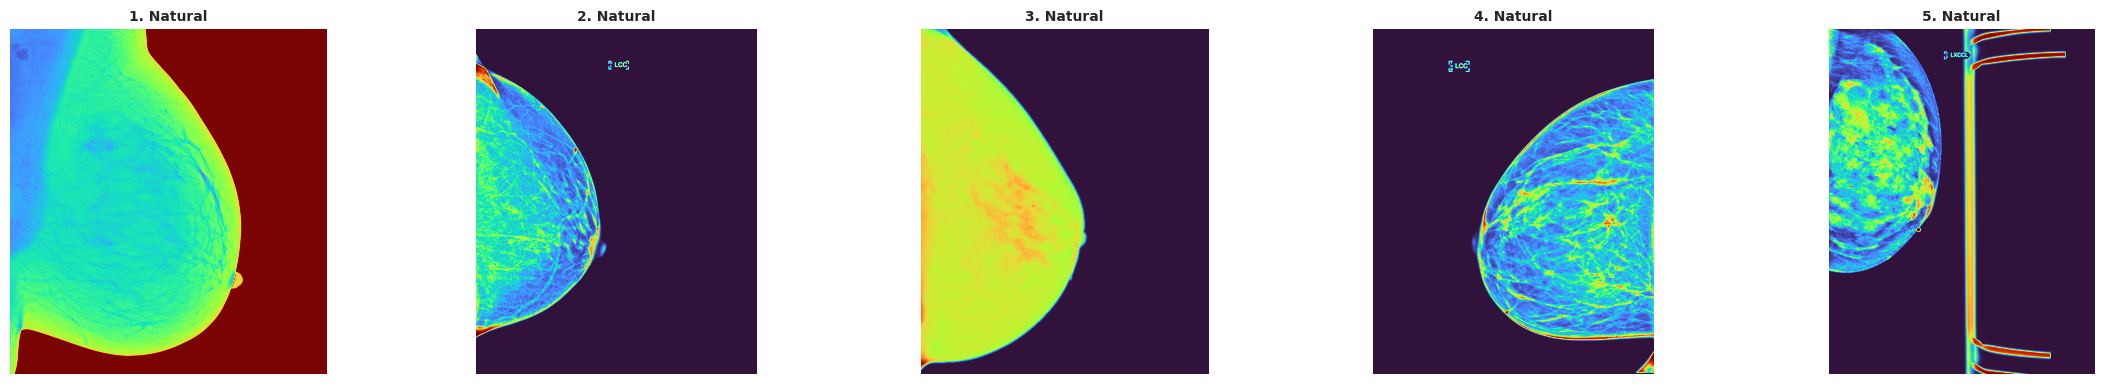

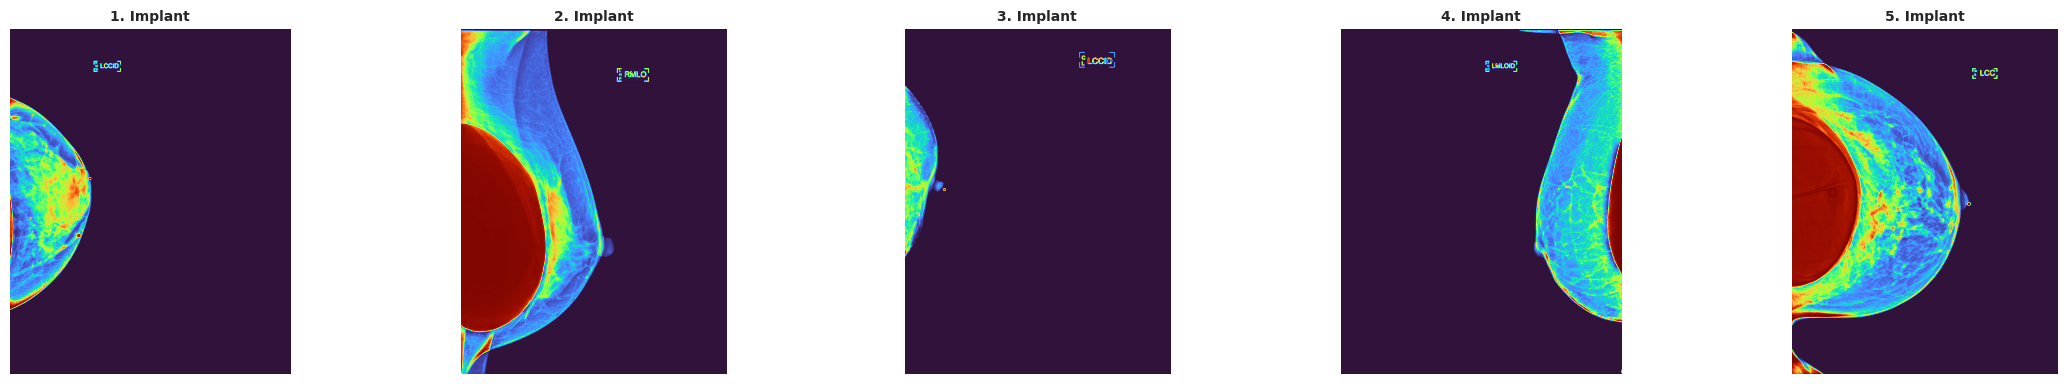

In [23]:
for implant_flag in train_df["implant"].unique().tolist():
    show_images_implant(col="implant", col_flag=implant_flag, sample_size=5, cancer_flag=1)